In [65]:
from sklearn.linear_model import Ridge
import numpy as np
import time
import string
# from copy import copy
import pickle
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import IPython
import itertools
from collections import defaultdict
from sklearn.cross_validation import cross_val_score
import sklearn.metrics

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Подготовка субтитров

In [3]:
umlautDictionary = {u'Ä': 'Ae', u'Ö': 'Oe', u'Ü': 'Ue',  u'ä': 'ae', u'ö': 'oe', u'ü': 'ue', u'ß':u'ss'}
with open('Forrest Gump.srt') as f_srt:
    text = f_srt.read()

text = text.split('\r\n')
text = filter(lambda s: s != u'', text)
print text[:5]

['1', '00:06:19,933 --> 00:06:24,404', 'Hallo. Mein Name ist Forrest.', 'Forrest Gump.', '2']


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [21]:
timestamps = filter(lambda s: '>' in s, text)
number_indecies = filter(lambda s: text[s].isdigit(), range(len(text)))
timestamp_indecies = filter(lambda s: text[s] in timestamps, range(len(text)))
text_indecies = filter(lambda s: not (s in number_indecies or s in timestamp_indecies) , range(len(text)))

assert len(timestamps) == len(number_indecies)

In [22]:
def timestamp_str_to_seconds(timestamp):
    
    def time_to_sec(time):
        time = time.split(':')
        return float(time[0]) * 60 * 60 + float(time[1]) * 60 + float(time[2])
    
    time_start, time_end = timestamp.split(' --> ')
    return time_to_sec(time_start), time_to_sec(time_end)

In [23]:
parsed_timestamps = map(lambda s: [time.strptime(s[:12], '%H:%M:%S,%f'), 
                            time.strptime(s[17:], '%H:%M:%S,%f')], timestamps)
print timestamps[0]
print parsed_timestamps[0][0].tm_hour, parsed_timestamps[0][0].tm_min, parsed_timestamps[0][0].tm_sec
print parsed_timestamps[0][1].tm_hour, parsed_timestamps[0][1].tm_min, parsed_timestamps[0][1].tm_sec

00:06:19,933 --> 00:06:24,404
0 6 19
0 6 24


In [24]:
timestamps = map(lambda s: s.replace(',', '.'), timestamps)
seconds = map(timestamp_str_to_seconds, timestamps)
print seconds[:5]

[(379.933, 384.404), (390.093, 391.924), (394.253, 398.61), (398.693, 403.403), (405.773, 409.08299999999997)]


In [25]:
table = string.maketrans("", "")
parsed_phrases = []

for i, phrase in enumerate(text):
    if i not in text_indecies:
        continue
    
    phrase = phrase.translate(table,string.punctuation)
    phrase = phrase.translate(table, string.digits)
    phrase = phrase.lower()
    phrase = phrase.split(' ')
    phrase = filter(lambda s: s != u'', phrase)
    
    if phrase != []:
        if i - 1 in text_indecies:
            parsed_phrases[-1].extend(phrase)
        else:
            parsed_phrases.append(phrase)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:12: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [35]:
srt = srt[srt.start < 18 * 60 + 5]

In [36]:
with open('subtitles_by_word_first_15_min.txt', 'wb')as f:
    for phrase in srt.text:
        for word in phrase:
            f.write(word + '\n')

In [30]:
assert len(parsed_phrases) == len(timestamps) == len(number_indecies)

In [29]:
srt = pd.DataFrame(columns=['start', 'end', 'text'])
srt.start = [seconds[i][0] for i in range(len(seconds))]
srt.end = [seconds[i][1] for i in range(len(seconds))]
srt.text = [parsed_phrases[i] for i in range(len(seconds))]

In [18]:
parsed_srt = zip(seconds, parsed_phrases)
for item in parsed_srt[:5]:
    print item

((1.0, 4.0), ['downloaded', 'from', 'wwwallsubsorg'])
((379.933, 384.404), ['hallo', 'mein', 'name', 'ist', 'forrest', 'forrest', 'gump'])
((390.093, 391.924), ['m\xc3\xb6chten', 'sie', 'eine', 'praline'])
((394.253, 398.61), ['die', 'k\xc3\xb6nnte', 'ich', 'pfundweise', 'essen'])
((398.693, 403.403), ['meine', 'mama', 'sagte', 'immer', 'das', 'leben', 'ist', 'wie', 'eine', 'schachtel', 'pralinen'])


# Подготовка описания сцен

In [1]:
description = pd.read_csv('german_audio_description.csv')
umlautDictionary = {u'Ä': 'Ae', u'Ö': 'Oe', u'Ü': 'Ue',  u'ä': 'ae', u'ö': 'oe', u'ü': 'ue', u'ß':u'ss'}

for i, phrase in enumerate(description.text):
    phrase = description.text[i].lower()
    phrase = phrase.translate(table,string.punctuation)
    phrase = phrase.translate(table, string.digits)
    phrase = phrase.decode('utf-8')
    for uml, norm_let in umlautDictionary.iteritems():
        phrase = phrase.replace(uml, norm_let)
    
    phrase = phrase.split()
    description.text[i] = phrase

NameError: name 'pd' is not defined

In [14]:
description.head()

,start,end,text
0,1.3,10.5,"[eine, computeranimation, auf, einen, schroffe..."
1,15.9,19.5,"[vor, bewoelktem, himmel, schwebt, eine, grauw..."
2,22.6,25.8,"[in, einer, stadt, segelt, sie, ueber, die, ba..."
3,31.7,36.7,"[ein, robertzemeckisfilm, tom, hanks, als, for..."
4,40.7,61.0,"[die, feder, fliegt, ein, paar, meter, ueber, ..."


In [16]:
srt_pd = pd.DataFrame(columns=['start', 'end', 'text'])
srt_pd.start = [parsed_srt[i][0][0] for i in range(len(parsed_srt))]
srt_pd.end = [parsed_srt[i][0][1] for i in range(len(parsed_srt))]
srt_pd.text = [parsed_srt[i][1] for i in range(len(parsed_srt))]

srt_pd.head()

,start,end,text
0,190.16,194.631,"[hallo, mein, name, ist, forrest, forrest, gump]"
1,200.32,202.151,"[m�chten, sie, eine, praline]"
2,204.48,208.837,"[die, k�nnte, ich, pfundweise, essen]"
3,208.92,213.630,"[meine, mama, sagte, immer, das, leben, ist, w..."
4,216.00,219.310,"[man, wei�, nie, was, man, kriegt]"


# Соединение субтитров и описания сцен

In [47]:
data = pd.concat([description, srt_pd])
data.sort(columns='start', inplace=True)
data.index = range(len(data))
data

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,start,end,text
0,1.30,10.500,"[eine, computeranimation, auf, einen, schroffe..."
1,15.90,19.500,"[vor, bewoelktem, himmel, schwebt, eine, grauw..."
2,22.60,25.800,"[in, einer, stadt, segelt, sie, ueber, die, ba..."
3,31.70,36.700,"[ein, robertzemeckisfilm, tom, hanks, als, for..."
4,40.70,61.000,"[die, feder, fliegt, ein, paar, meter, ueber, ..."
5,68.70,73.000,"[in, der, naehe, eines, kirchturms, sinkt, die..."
6,77.00,91.500,"[die, hoerfilmfassung, wurde, produziert, vom,..."
7,93.00,101.000,"[die, feder, trudelt, zu, einer, strasse, hinu..."
8,105.60,124.900,"[der, mann, ueberquert, die, fahrbahn, die, fe..."
9,126.20,145.700,"[der, mann, hebt, sie, auf, und, betrachtet, s..."


# Удаление сцен

In [48]:
# http://www.nature.com/articles/sdata20143/tables/1

times_to_stay = [
'00:00:00.00 --> 00:21:32.12',
'00:24:13.24 --> 00:38:31.23', 
'00:38:58.20 --> 00:57:19.22', 
'00:59:31.17 --> 01:18:14.00', 
'01:20:24.16 --> 01:34:18.06', 
'01:37:14.19 --> 01:41:30.19',
'01:42:49.19 --> 02:09:51.17']

times_to_stay = map(timestamp_str_to_seconds, times_to_stay)
times_to_stay

[(0.0, 1292.12),
 (1453.24, 2311.23),
 (2338.2, 3439.22),
 (3571.17, 4694.0),
 (4824.16, 5658.06),
 (5834.19, 6090.19),
 (6169.19, 7791.17)]

In [49]:
def is_in_stimulus(record, times_to_stay=times_to_stay):
    for time_moment_start, time_moment_end in times_to_stay:
        if time_moment_start <= record.start and time_moment_end >= record.end:
            return True
        
    return False

In [50]:
data = data.ix[[i for i in range(len(data)) if is_in_stimulus(data.ix[i])]]

In [51]:
data

,start,end,text
0,1.30,10.500,"[eine, computeranimation, auf, einen, schroffe..."
1,15.90,19.500,"[vor, bewoelktem, himmel, schwebt, eine, grauw..."
2,22.60,25.800,"[in, einer, stadt, segelt, sie, ueber, die, ba..."
3,31.70,36.700,"[ein, robertzemeckisfilm, tom, hanks, als, for..."
4,40.70,61.000,"[die, feder, fliegt, ein, paar, meter, ueber, ..."
5,68.70,73.000,"[in, der, naehe, eines, kirchturms, sinkt, die..."
6,77.00,91.500,"[die, hoerfilmfassung, wurde, produziert, vom,..."
7,93.00,101.000,"[die, feder, trudelt, zu, einer, strasse, hinu..."
8,105.60,124.900,"[der, mann, ueberquert, die, fahrbahn, die, fe..."
9,126.20,145.700,"[der, mann, hebt, sie, auf, und, betrachtet, s..."


In [52]:
data.to_csv('german_subs_and_description.csv')

# Разбиение на сегменты

In [54]:
# http://www.nature.com/articles/sdata20143/#f2
segments_time = [902., 882., 876., 976., 924., 878., 1084., 675.]

In [60]:
data['duration'] = data.end - data.start

In [61]:
data['total_time'] = np.cumsum(data.duration)

In [68]:
data[data.total_time > 890].head()

,start,end,text,duration,total_time
242,1030.64,1034.474,"[wissen, sie, noch, dass, ich, sagte, jenny, w...",3.834,893.539
243,1034.56,1037.950,"[sie, wohnte, in, einem, haus, das, war, so, a...",3.390,896.929
244,1038.04,1040.474,"[ihre, mama, kam, in, den, himmel, als, sie, f...",2.434,899.363
245,1040.56,1044.917,"[und, ihr, daddy, war, irgendein, farmer]",4.357,903.720
246,1045.00,1046.797,[jenny],1.797,905.517


In [70]:
data.head()

,start,end,text,duration,total_time
0,1.3,10.5,"[eine, computeranimation, auf, einen, schroffe...",9.2,9.2
1,15.9,19.5,"[vor, bewoelktem, himmel, schwebt, eine, grauw...",3.6,12.8
2,22.6,25.8,"[in, einer, stadt, segelt, sie, ueber, die, ba...",3.2,16.0
3,31.7,36.7,"[ein, robertzemeckisfilm, tom, hanks, als, for...",5.0,21.0
4,40.7,61.0,"[die, feder, fliegt, ein, paar, meter, ueber, ...",20.3,41.3


In [95]:
print data.duration.max(), data.duration.min()

20.3 0.5


# Подготовка данных МРТ

In [14]:
with open('forrest_align_by_word_first_15_min.txt', 'r') as f:
    records = f.readlines()
    
records = map(lambda s: s.strip().split(), records)
records = map(lambda s: [float(s[1]) + 180., float(s[2]) + 180., s[3][1 : -1]], records)
records[:5]

[[180.0, 189.04, 'hallo'],
 [189.04, 190.96, 'mein'],
 [190.96, 191.4, 'name'],
 [191.4, 191.64, 'ist'],
 [191.64, 192.36, 'forrest']]

In [15]:
record_pd = pd.DataFrame(columns=['start', 'end', 'word'], data=records)

In [16]:
mri = nib.load('bold.nii.gz')
mri_data= mri.get_data()
mri_data.shape

(160, 160, 36, 451)

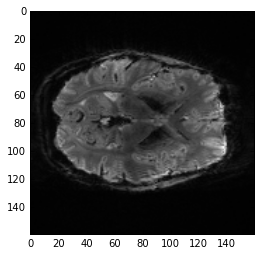

In [93]:
for i in range(20):
    IPython.display.clear_output()
    plt.imshow(mri_data[:, :, 16, i], cmap='gray')
    plt.show()
    time.sleep(0.5)

In [17]:
with open('word2vec_german_sub_Forrest_Gump.pickle', 'rb') as f_dict:
    dictionary = pickle.load(f_dict)

In [18]:
def def_dict(word):
    if word in dictionary.keys():
        return dictionary[word]

In [19]:
record_pd['vector'] = map(def_dict, record_pd['word'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  from ipykernel import kernelapp as app


In [20]:
record_pd.head()

,start,end,word,vector
0,180.00,189.04,hallo,"[-0.00216967, -0.0205193, 0.0924138, 0.187472,..."
1,189.04,190.96,mein,"[0.332542, -0.0170897, 0.127019, 0.117337, 0.0..."
2,190.96,191.40,name,"[-0.230506, 0.0665354, -0.15426, 0.465509, 0.0..."
3,191.40,191.64,ist,"[0.146284, -0.0737619, -0.0211892, -0.0542237,..."
4,191.64,192.36,forrest,"[0.0369523, -0.027655, -0.176746, -0.235293, -..."


In [ ]:
record_pd.to_csv('german_sub_1_segment.csv')

# Соединение данных МРТ и стимулов

In [2]:
record_pd = pd.read_csv('german_sub_1_segment.csv')

In [118]:
weights = defaultdict(list)
EPS = 0.1

In [119]:
record_pd = record_pd.dropna()

In [123]:
def get_ridge_weights(pairs_list, dta=record_pd):#, alpha=0.005):
    X = map(lambda ind: record_pd.ix[ind[0]].vector, pairs_list)
    y = np.array([pair[1] for pair in pairs_list])
    
    print 'r2 score: ', cross_val_score(Ridge(), X, y=y, scoring='r2').mean()
    
    ridge_regr = Ridge()
    ridge_regr.fit(X, y)
    
    #print sklearn.metrics.mean_squared_error(y, ridge_regr.predict(X))
    
    return ridge_regr.coef_

In [ ]:
#sum_data = 0.
#counter = 0.

for x, y, z in itertools.product(range(mri_data.shape[0]),
                                range(mri_data.shape[1]), 
                                range(mri_data.shape[2])):

    pairs = []
    print x,y,z

    for t in range(94, mri_data.shape[-1]):
        t_sec_end = 2 * t
        t_sec_start = 2 * t - 2
        time_data = record_pd.ix[record_pd.start > t_sec_start - EPS]
        time_data = time_data.ix[time_data.end < t_sec_end + EPS]
        #print t

        if len(time_data) > 0:
            #sum_data += len(time_data)
            #counter += 1
            for i in time_data.index:
                pairs.append([i, mri_data[x,y,z,t]])
                #all_data[(x,y,z)].append([i, mri_data[x,y,z,t]])
                #all_data[(50,20,21)].append([i, mri_data[50,20,21,t]])
        
    weights[(x,y,z)] = get_ridge_weights(pairs)

0 0 0
r2 score:  1.0
0 0 1
r2 score:  1.0
0 0 2
r2 score:  1.0
0 0 3
r2 score:  1.0
0 0 4
r2 score:  1.0
0 0 5
r2 score:  1.0
0 0 6
r2 score:  1.0
0 0 7
r2 score:  1.0
0 0 8
r2 score:  1.0
0 0 9
r2 score:  1.0
0 0 10
r2 score:  1.0
0 0 11
r2 score:  1.0
0 0 12
r2 score:  1.0
0 0 13
r2 score:  1.0
0 0 14
r2 score:  1.0
0 0 15
r2 score:  1.0
0 0 16
r2 score:  1.0
0 0 17
r2 score:  1.0
0 0 18
r2 score:  1.0
0 0 19
r2 score:  1.0
0 0 20
r2 score:  1.0
0 0 21
r2 score:  1.0
0 0 22
r2 score:  1.0
0 0 23
r2 score:  1.0
0 0 24
r2 score:  1.0
0 0 25
r2 score:  1.0
0 0 26
r2 score:  1.0
0 0 27
r2 score:  1.0
0 0 28
r2 score:  1.0
0 0 29
r2 score:  1.0
0 0 30
r2 score:  1.0
0 0 31
r2 score:  1.0
0 0 32
r2 score:  1.0
0 0 33
r2 score:  1.0
0 0 34
r2 score:  1.0
0 0 35
r2 score:  1.0
0 1 0
r2 score:  1.0
0 1 1
r2 score:  1.0
0 1 2
r2 score:  1.0
0 1 3
r2 score:  1.0
0 1 4
r2 score:  1.0
0 1 5
r2 score:  1.0
0 1 6
r2 score:  1.0
0 1 7
r2 score:  1.0
0 1 8
r2 score:  1.0
0 1 9
r2 score:  1.0
0 1 10
r